# Pairwise Fst between populations

In [1]:
import hail as hl
hl.init(spark_conf={'spark.driver.memory': '10g'}, tmp_dir='/home/olavur/tmp')

2021-11-25 12:13:17 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2021-11-25 12:13:18 WARN  Hail:37 - This Hail JAR was compiled for Spark 2.4.5, running with Spark 2.4.1.
  Compatibility is not guaranteed.


Running on Apache Spark version 2.4.1
SparkUI available at http://hms-beagle-68c965f6f5-qw44l:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.61-3c86d3ba497a
LOGGING: writing to /home/olavur/experiments/2020-11-13_fargen1_exome_analysis/fargen-1-exome/notebooks/gnomad_exome_sites/hail-20211125-1213-0.2.61-3c86d3ba497a.log


In [2]:
from bokeh.io import show, output_notebook
from bokeh.layouts import gridplot
from bokeh.models.scales import LogScale
output_notebook()

Loading BokehJS ...

In [3]:
import numpy as np
import pandas as pd
from seaborn import clustermap

In [4]:
BASE_DIR = '/home/olavur/experiments/2020-11-13_fargen1_exome_analysis'

## Load merged FarGen and gnomAD allele frequency data

In [11]:
af_ht = hl.read_table(BASE_DIR + '/data/resources/gnomad_exome_sites/fargen_gnomad_union_filtered.ht')

In [6]:
n_variants = af_ht.count()
print('Number of variants: ' + str(n_variants))

Number of variants: 15692611


## Reduction in heterozygosity due to population subdivision, Fst

**TODO:** How do I aggregate $F_{st}$ values across loci? Is ther a better way than using the mean $F_{st}$?

**NOTE:** There are way more advanced methods of calculating population subdivision than the simple $F_{st}$.

Given two populations having allele frequencies $p_1$ and $p_2$ at some locus, we define the the fixation index, the reduction of heterozygosity due to population subdivision, as

$$
F_{ST} = \frac{H_T - H_S}{H_T}
$$

where $H_T = 2\bar p (1 - \bar p)$ is the heterozygosity in the total population, where the allele frequency is averaged over subpopulations, and $H_S = \frac{1}{n} \sum_{i=1}^n 2 p_i (1 - p_i)$ is the average heterozygosity in the subpopulations.

In [7]:
def calc_Fst(ht, af1_exprs, af2_exprs):
    '''
    Input:
    ht:            HailTable or MatrixTable
    af1_exprs:     Float64Expression, allele frequency in population 1.
    af2_exprs:     Float64Expression, allele frequency in population 2.
    
    Returns:
    Float, Fst averaged over all sites where total heterozygosity is greater than zero.
    '''
    # Allele frequency in total population is the average of the two fequencies.
    avg_allele_freq_exprs = (af1_exprs + af2_exprs) / 2

    # Calculate HWE expected heterozygosity of total population, usually noted as H_t.
    total_heterozygosity_exprs = 2 * avg_allele_freq_exprs * (1 - avg_allele_freq_exprs)

    # Calculate the average of the expected heterozygosities in the subpopulations, H_s.
    avg_subpop_heterozygosity_exprs = af1_exprs * (1 - af1_exprs) + af2_exprs * (1 - af2_exprs)

    # Calculate reduction in heterozygosity due to subdivision.
    Fst_exprs = (total_heterozygosity_exprs - avg_subpop_heterozygosity_exprs) / total_heterozygosity_exprs

    # Calculate the mean Fst between the two populations.
    # Fst is not defined where the total heterozygosity is 0, as it is infinite, so we do not include such sites in the mean.
    Fst = ht.aggregate(hl.agg.filter(total_heterozygosity_exprs != 0, hl.agg.mean(Fst_exprs)))
    
    return Fst

Calculate the Fst between the Faroese population and the entire gnomAD population.

In [8]:
%%time

Fst = calc_Fst(af_ht, af_ht.info.AF_fae, af_ht.info.AF_gnomad_all)

print('Reduction in heterozygosity between FarGen and gnomAD (all) populations: {Fst:.5f}'.format(Fst=Fst))

[Stage 0:=================================================> (9764 + 24) / 10034]

Reduction in heterozygosity between FarGen and gnomAD (all) populations: 0.00690
CPU times: user 51.8 ms, sys: 16.6 ms, total: 68.4 ms
Wall time: 19 s


### Pairwise Fst

A list of populations to use.

In [29]:
#pop_list = ['fae', 'afr', 'sas', 'amr', 'eas', 'nfe', 'fin', 'nfe_nwe', 'nfe_seu']
pop_list = ['AF_fae', 'AF_nfe', 'AF_fin', 'AF_nfe_nwe']

#pop_name_list = ['Faroese', 'African', 'SE Asian', 'American', 'E Asian', 'European', 'Finnish', 'NW European', 'S European']
pop_name_list = ['Faroese', 'European', 'Finnish', 'NW European']

n_pops = len(pop_list)

We will populate a numpy array with Fst values.

In [30]:
pairwise_fst = np.zeros((n_pops, n_pops))

In [31]:
%%time
for i in range(n_pops):
    for j in range(i + 1, n_pops):
        pop1 = pop_list[i]
        pop2 = pop_list[j]
        #print(pop1, pop2)
        
        af1_exprs = af_ht.info[pop1]
        af2_exprs = af_ht.info[pop2]
        
        pairwise_fst[i,j] = calc_Fst(af_ht, af1_exprs, af2_exprs)

[Stage 6:==============================================>    (9179 + 24) / 10034]

CPU times: user 192 ms, sys: 70.6 ms, total: 263 ms
Wall time: 1min 23s


[Stage 6:=================================================> (9700 + 24) / 10034]

We have only calculated the upper triangular of this matrix. As it should be symmetric, we can add the transpose to the matrix to obtain the full matrix.

In [32]:
pairwise_fst_sym = pairwise_fst + pairwise_fst.T

We are not interested in seeing the diagonal in the plot, so we remove this.

In [33]:
mask_diag = np.zeros(pairwise_fst_sym.shape, dtype=bool)
diag_idx = np.diag_indices_from(mask_diag)
mask_diag[diag_idx] = True

In [34]:
pairwise_fst_pd = pd.DataFrame(pairwise_fst_sym, columns=pop_name_list, index=pop_name_list)

We make a heatmap of the Fst matrix with a dendrogram showing the clustering. Note that the European and North-Western European populations do not contain Finns.

/opt/conda/envs/fargen-1-exome/lib/python3.7/site-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


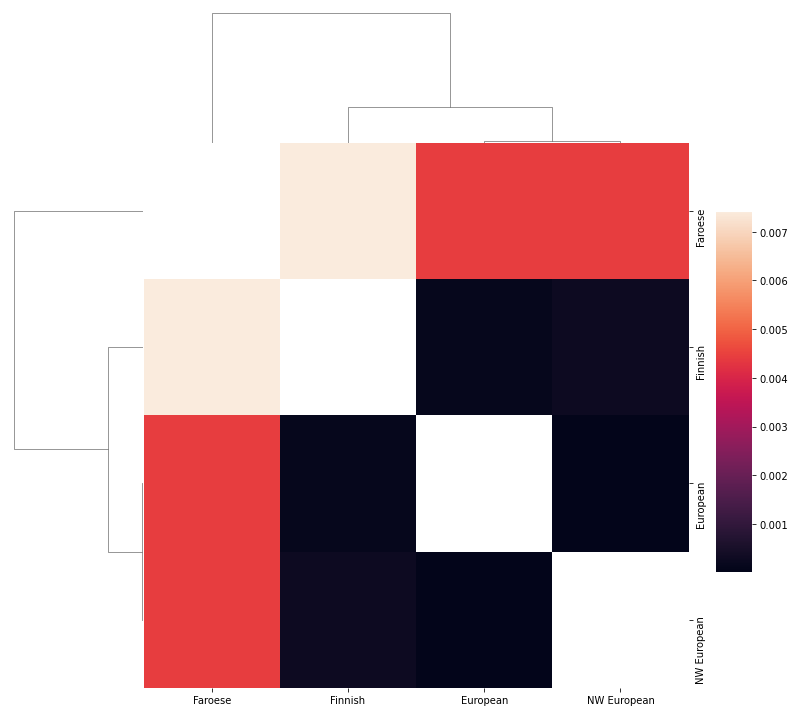

In [35]:
plt = clustermap(pairwise_fst_pd, mask=mask_diag, row_cluster=True, cbar_pos=(1, 0.2, 0.05, 0.5))

Save this plot to file.

In [36]:
plt.savefig(BASE_DIR + '/data/figures/pairwise_Fst_gnomAD.png')

Print the table of Fst values.

In [37]:
pairwise_fst_pd

,Faroese,European,Finnish,NW European
Faroese,0.000000,0.004413,0.007413,0.004435
European,0.004413,0.000000,0.000127,0.000020
Finnish,0.007413,0.000127,0.000000,0.000267
NW European,0.004435,0.000020,0.000267,0.000000


Write Fst table to file.

In [38]:
pairwise_fst_pd.to_csv(BASE_DIR + '/data/results/pairwise_Fst_gnomAD.csv')